# emodpy-hiv simple campaign example
This notebook provides a example of using emodpy-hiv to commission an EMOD (DTK) simulation of HIV transmission on COMPS. It uses publicly available demographics data from Uganda. First, we will import all required packages.

In [1]:
import workspace

In [2]:
import pathlib # for a join
from functools import partial  # for setting Run_Number. In Jonathan Future World, Run_Number is set by dtk_pre_proc based on generic param_sweep_value...
import os

# idmtools ...
from idmtools.assets import Asset, AssetCollection  #
from idmtools.builders import SimulationBuilder
from idmtools.core.platform_factory import Platform
from idmtools.entities.experiment import Experiment
from idmtools_platform_comps.utils.python_requirements_ac.requirements_to_asset_collection import RequirementsToAssetCollection
from idmtools_models.templated_script_task import get_script_wrapper_unix_task

# emodpy
from emodpy.emod_task import EMODTask
from emodpy.utils import EradicationBambooBuilds
from emodpy.bamboo import get_model_files
from emodpy_hiv.interventions.cascade_helpers import *
import emodpy_hiv.interventions.utils as hiv_utils
import emod_api.interventions.common as comm
from emodpy_hiv.download import download

import params
import manifest
import campaign_knobs as ck

ART_eligible_tag="Accessibility:Easy"

We will start with a baseline campaign that only infects and transmits HIV in the population before adding additional factors like STI co-infection or antiretroviral (ART) distribution.

In [3]:
def build_camp( art_coverage = 1.0 ):
    """
        Build a campaign input file for the DTK using emod_api type functions or helpers from this module. 
        Note that 'camp' is short for 'campaign'.
        You can name this function whatever you want, it just has to match what you pass in from_default2.
    """

    # Setup
    import emod_api.campaign as camp
    camp.set_schema( manifest.schema_file )

    def timestep_from_year( year ):
        return (year-params.base_year)*365

    # Crudely seed the infection
    event = ob.seed_infections( camp, start_day=timestep_from_year( 1961.5 ) )
    camp.add( event )

    return camp

Next, we add a few small functions to help with parameter sweeps.

In [4]:
def update_sim_bic(simulation, value):
    """
        Update the value of a (scientific) configuration parameter, in this case Base_Infectivity_Constant 
        (which may or may not be part of this sim_type's parameters), as part of a sweep.
    """
    simulation.task.config.parameters.Base_Infectivity_Constant = value*0.1
    return {"Base_Infectivity": value}

def update_sim_random_seed(simulation, value):
    """
        Update the value of the Run_Number as part of the most basic configuration sweep example.
    """
    simulation.task.config.parameters.Run_Number = 3

def art_coverage_test_sweep( simulation, sweep_param ):
    art_coverage = sweep_param/10.0
    build_campaign_partial = partial( build_camp, art_coverage )
    simulation.task.create_campaign_from_callback( build_campaign_partial )
    return {"ART_Target_Coverage": art_coverage }

This function builds the EMOD configuration file:

In [5]:
def set_param_fn( config ):
    """
        Set the configuration parameters. Every parameter must be in the schema and every value must be valid
        per the schema. You usually don't need to set Enable's as they are set implicitly now. Refer to the schema
        for the possible params for your model. You can name this function whatever you want, it just has to 
        match what you pass in from_default2.
    """
    config.parameters.Simulation_Duration = 35300
    config.parameters.Simulation_Timestep = 30.4166666666667
    config.parameters.Start_Time = 0
    config.parameters.Base_Year = params.base_year
    config.parameters.Run_Number = 11016

    # config hacks until schema fixes arrive
    config.parameters.pop( "Serialized_Population_Filenames" )
    config.parameters.pop( "Serialization_Time_Steps" )

    import conf
    conf.set_config( config )
    config.parameters.Report_Event_Recorder_Events = [
      "NewInfectionEvent",
      "HIVSymptomatic",
      "STIDebut"
    ]

    import emodpy_hiv.utils as config_utils
    config_utils.non_schema_checks( config )

    return config

This function builds the EMOD demographics file:

In [6]:
def build_demog():
    """
        Build a demographics input file for the DTK using emod_api. 
    """
    import emodpy_hiv.demographics.HIVDemographics as Demographics # OK to call into emod-api
    import emod_api.demographics.Demographics as demo
    import emod_api.demographics.DemographicsTemplates as DT

    demog = Demographics.from_template_node( lat=0, lon=0, pop=100000, name=1, forced_id=1 )
    demog.SetEquilibriumAgeDistFromBirthAndMortRates()
    demog.fertility( "Malawi_Fertility_Historical.csv" )
    demog.mortality( "Malawi_male_mortality.csv", "Malawi_female_mortality.csv" )

    demog.AddIndividualPropertyAndHINT( Property="Accessibility", Values=["Easy","Hard"], InitialDistribution=[0.0, 1.0] )
    demog.AddIndividualPropertyAndHINT( Property="Risk", Values=["LOW","MEDIUM","HIGH"], InitialDistribution=[0.99, 0, 0.01] )
    demog.AddIndividualPropertyAndHINT( Property="TestingStatus", Values=["INELIGIBLE","ELIGIBLE"], InitialDistribution=[1.0, 0 ] )
    demog.apply_assortivity( "COMMERCIAL", [ [1,1,1],[1,1,1],[1,1,1] ] )

    return demog

With those input files created, we are now ready to define the compute platform. We're going to run on the Calculon environment (on COMPS).

In [7]:
platform = Platform("Calculon", node_group="idm_48cores", priority="Highest") 


[Calculon]
{
   "endpoint": "https://comps.idmod.org",
   "environment": "Calculon"
}


Next we download some CSV input files containing demographics data from the data server.

In [8]:
!wget "http://ipadvweb02.linux.idm.ctr:8000/Malawi/Malawi_Fertility_Historical.csv"
!wget "http://ipadvweb02.linux.idm.ctr:8000/Malawi/Malawi_female_mortality.csv"
!wget "http://ipadvweb02.linux.idm.ctr:8000/Malawi/Malawi_male_mortality.csv"

--2021-10-06 13:43:08--  http://ipadvweb02.linux.idm.ctr:8000/Malawi/Malawi_Fertility_Historical.csv
Resolving ipadvweb02.linux.idm.ctr (ipadvweb02.linux.idm.ctr)... 10.24.40.12
Connecting to ipadvweb02.linux.idm.ctr (ipadvweb02.linux.idm.ctr)|10.24.40.12|:8000... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1194 (1.2K) [text/csv]
Saving to: ‘Malawi_Fertility_Historical.csv.1’

Malawi_Fertility_Hi 100%[===================>]   1.17K  --.-KB/s    in 0s      

2021-10-06 13:43:08 (231 MB/s) - ‘Malawi_Fertility_Historical.csv.1’ saved [1194/1194]

--2021-10-06 13:43:08--  http://ipadvweb02.linux.idm.ctr:8000/Malawi/Malawi_female_mortality.csv
Resolving ipadvweb02.linux.idm.ctr (ipadvweb02.linux.idm.ctr)... 10.24.40.12
Connecting to ipadvweb02.linux.idm.ctr (ipadvweb02.linux.idm.ctr)|10.24.40.12|:8000... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13606 (13K) [text/csv]
Saving to: ‘Malawi_female_mortality.csv.1’

Malawi_female_morta 100%[==========

In [9]:
import emod_hiv.bootstrap as dtk
dtk.setup(pathlib.Path(manifest.eradication_path).parent)

In [10]:
task = EMODTask.from_default2(config_path="config.json", eradication_path=manifest.eradication_path, campaign_builder=build_camp, demog_builder=build_demog, schema_path=manifest.schema_file, param_custom_cb=set_param_fn, ep4_custom_cb=None)
task.set_sif( "dtk_centos.id" )

Wrote 'default_config.json' file.
DEBUG: write_config_from_default_and_params invoked with default_config.json, <function set_param_fn at 0x7f674245b598>.
DEBUG: Calling load_default_config_as_rod.
DEBUG: Calling set_fn.
Fertility data file column names are ountry, NA, ID, Nothing, AreaCode, Years, 15-19, 20-24, 25-29, 30-34, 35-39, 40-45, 45-49
Found 15 rows of fertility data.
Generating demographics file demographics.json.
Campaign builder save returned campaign.json as file.


In [11]:
builder = SimulationBuilder()
builder.add_sweep_definition( art_coverage_test_sweep, range(params.nSims) )
experiment = Experiment.from_builder(builder, task, name=params.exp_name) 

In [12]:
experiment.run(wait_until_done=True, platform=platform)

# Check result
if not experiment.succeeded:
    print(f"Experiment {experiment.uid} failed.\n")
    exit()

print(f"Experiment {experiment.uid.hex} succeeded.")

manifest.output_files_to_get = "output/InsetChart.json"
download( experiment.uid.hex, manifest.output_dl_folder, manifest.output_files_to_get )


The created experiment can be viewed at https://comps.idmod.org/#explore/Simulations?filters=ExperimentId=c3f581fb-cc26-ec11-9ecd-9440c9bee941
Simulations are still being created



Initializing objects for creation: 0simulation [00:00, ?simulation/s]

Campaign builder save returned campaign.json as file.


Creating Simulations on Comps:   0%|          | 0/1 [00:00<?, ?simulation/s]        

Creating Simulations on Comps: 100%|██████████| 1/1 [00:00<00:00,  6.77simulation/s]
Waiting on Experiment HIV Rakai Simpler CoC to Finish running: 100%|██████████| 1/1 [00:30<00:00, 30.68s/simulation]

Experiment c3f581fbcc26ec119ecd9440c9bee941 succeeded.

[Calculon]
{
   "endpoint": "https://comps.idmod.org",
   "environment": "Calculon"
}


Attempting to download ['output/InsetChart.json'] for experiment c3f581fbcc26ec119ecd9440c9bee941 into COMPS_output_downloads.
Creating Watcher

The running WorkItem can be viewed at https://comps.idmod.org/#explore/WorkItems?filters=Id=7b71210e-cd26-ec11-9ecd-9440c9bee941



Waiting on WorkItem Filter outputs for Experiment c3f581fb-cc26-ec11-9ecd-9440c9bee941: 100%|██████████| 1/1 [00:05<00:00,  5.08s/workitem]

Removing COMPS_output_downloads/output.zip
Deleting workitem 7b71210e-cd26-ec11-9ecd-9440c9bee941


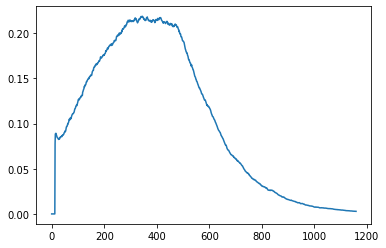

In [13]:
simdir = os.listdir( manifest.output_dl_folder )[-1]
import json
hiv_prev_baseline = json.load( open( manifest.output_dl_folder + "/" + simdir + "/output/InsetChart.json" ) )["Channels"]["Infected"]["Data"]
import matplotlib.pyplot as plt
plt.plot( hiv_prev_baseline )

Now let's add some detail to the model by incorporating STI co-infections. We distribute STIs to certain percentages of the population, which then increases an individual's risk of acquiring HIV upon exposure.

In [14]:
def _add_sti_by_risk_and_coverage( camp, risk, coverage, include_ongoing=True ):
    """
    Internal function to do the "dirty work" to support add_sti_coinfection_complex.
    1) Add a 'scheduled' campaign event to give some %age of people in a given risk group an STI (co-)infection.
    2) Optionally add a 'triggered' campaign event (at STIDebut) to give some %age of people in a given risk group an STI (co-)infection.
    """
    import emodpy_hiv.interventions.modcoinf as coinf
    set_sti_coinf = coinf.new_intervention( camp )
    set_sti_coinf["Intervention_Name"] = "Pick_Up_A_Nasty"
    signal = hiv_utils.broadcast_event_immediate( camp, "CaughtNonHIVSTI" )

    event = comm.ScheduledCampaignEvent( camp, Start_Day=1, Event_Name="STI Co-Infection Setup", Intervention_List=[set_sti_coinf,signal], Property_Restrictions=risk, Demographic_Coverage=coverage )
    event.Event_Coordinator_Config.pop( "Targeting_Config" )
    camp.add( event )

    if include_ongoing:
        add_triggered_event( camp, in_trigger="STIDebut", out_iv=[set_sti_coinf,signal], coverage=coverage, target_risk=risk, event_name="STI Co-Infection Setup" )


def add_sti_coinfection_complex( camp, low_coverage=0.1, med_coverage=0.3, high_coverage=0.3 ):
    """
    # ScheduledCampaignEvent @ t=0:
    Folks with Risk=LOW get one prob (10%) of STI CoInf
    Folks with Risk=MED or HIGH get another prob (30%) of STI CoInf

    TriggeredCampaigEvent @ OnDebut:
        Same thing as above.
    """
    _add_sti_by_risk_and_coverage( camp, "Risk:LOW", low_coverage, include_ongoing=True )
    _add_sti_by_risk_and_coverage( camp, "Risk:MEDIUM", med_coverage, include_ongoing=True )
    _add_sti_by_risk_and_coverage( camp, "Risk:HIGH", high_coverage, include_ongoing=True )

Now we add the STI co-infections to the campaign and run the simulation again.

In [15]:
def build_camp( art_coverage = 1.0 ):
    """
        Build a campaign input file for the DTK using emod_api type functions or helpers from this module. 
        Note that 'camp' is short for 'campaign'.
        You can name this function whatever you want, it just has to match what you pass in from_default2.
    """

    # Setup
    import emod_api.campaign as camp
    camp.set_schema( manifest.schema_file )

    def timestep_from_year( year ):
        return (year-params.base_year)*365

    # Crudely seed the infection
    event = ob.seed_infections( camp, start_day=timestep_from_year( 1961.5 ) )
    camp.add( event )

    add_sti_coinfection_complex(camp, ck.STI_Low_Risk_Coverage, ck.STI_Med_Risk_Coverage, ck.STI_High_Risk_Coverage)
    return camp

task = EMODTask.from_default2(config_path="config.json", eradication_path=manifest.eradication_path, campaign_builder=build_camp, demog_builder=build_demog, schema_path=manifest.schema_file, param_custom_cb=set_param_fn, ep4_custom_cb=None)
experiment  = Experiment.from_builder(builder, task, name=params.exp_name) 
experiment.run(wait_until_done=True, platform=platform)

Wrote 'default_config.json' file.
DEBUG: write_config_from_default_and_params invoked with default_config.json, <function set_param_fn at 0x7f674245b598>.
DEBUG: Calling load_default_config_as_rod.
DEBUG: Calling set_fn.
Fertility data file column names are ountry, NA, ID, Nothing, AreaCode, Years, 15-19, 20-24, 25-29, 30-34, 35-39, 40-45, 45-49
Found 15 rows of fertility data.
Generating demographics file demographics.json.
Campaign is publishing the following events:
CaughtNonHIVSTI
Campaign is listening to the following events:
STIDebut
Campaign is IGNORING the following events:
CaughtNonHIVSTI
Campaign is LISTENING to the following non-campaign events:
STIDebut
Campaign builder save returned campaign.json as file.
Found adhoc events in campaign. Needs some special processing behind the scenes.

The created experiment can be viewed at https://comps.idmod.org/#explore/Simulations?filters=ExperimentId=92eb9f18-cd26-ec11-9ecd-9440c9bee941
Simulations are still being created



Initializing objects for creation: 0simulation [00:00, ?simulation/s]

Campaign is publishing the following events:
CaughtNonHIVSTI
Campaign is listening to the following events:
STIDebut
Campaign is IGNORING the following events:
CaughtNonHIVSTI
Campaign is LISTENING to the following non-campaign events:
STIDebut
Campaign builder save returned campaign.json as file.


Creating Simulations on Comps:   0%|          | 0/1 [00:00<?, ?simulation/s]            

Found adhoc events in campaign. Needs some special processing behind the scenes.


Creating Simulations on Comps: 100%|██████████| 1/1 [00:00<00:00, 14.63simulation/s]
Waiting on Experiment HIV Rakai Simpler CoC to Finish running: 100%|██████████| 1/1 [00:50<00:00, 50.78s/simulation]



[Calculon]
{
   "endpoint": "https://comps.idmod.org",
   "environment": "Calculon"
}
Attempting to download ['output/InsetChart.json'] for experiment 92eb9f18cd26ec119ecd9440c9bee941 into COMPS_output_downloads.
Creating Watcher

The running WorkItem can be viewed at https://comps.idmod.org/#explore/WorkItems?filters=Id=49bdca34-cd26-ec11-9ecd-9440c9bee941



Waiting on WorkItem Filter outputs for Experiment 92eb9f18-cd26-ec11-9ecd-9440c9bee941: 100%|██████████| 1/1 [00:10<00:00, 10.15s/workitem]

Removing COMPS_output_downloads/output.zip
Deleting workitem 49bdca34-cd26-ec11-9ecd-9440c9bee941


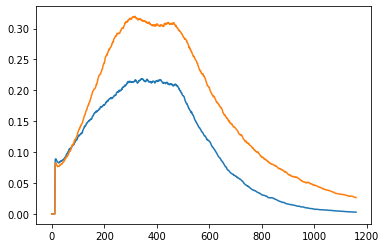

In [16]:
download( experiment.uid.hex, manifest.output_dl_folder, manifest.output_files_to_get )
subdir = os.listdir(manifest.output_dl_folder)[-1]
hiv_prev = json.load( open( manifest.output_dl_folder + "/" + subdir + "/" + "output/InsetChart.json" ) )["Channels"]["Infected"]["Data"]
plt.plot( hiv_prev_baseline )
plt.plot( hiv_prev )

You can see that adding STI co-infection has made quite a difference (baseline in blue).

Now we're going to layer in "Commercial Sex Workers" (CSWs) as follows:

In [17]:
def add_csw( camp ):
    # STIDebut -(HIVDelay)-> Uptake -(PVC)-> Dropout (PVC)
    male_delayed_uptake = hiv_utils.broadcast_event_delayed( camp, "CSW_Uptake", delay={ "Delay_Period_Mean": ck.CSW_Male_Uptake_Delay, "Delay_Period_Std_Dev": 30.0 } )
    female_delayed_uptake = hiv_utils.broadcast_event_delayed( camp, "CSW_Uptake", delay={ "Delay_Period": ck.CSW_Male_Uptake_Delay } )

    # 1: STIDebut->Uptake delay (males)
    add_triggered_event( camp, in_trigger="STIDebut", out_iv=male_delayed_uptake, event_name="Male CSW Debut->Uptake", coverage=ck.CSW_Male_Uptake_Coverage, target_sex="Male" )

    # 2: STIDebut->Uptake delay (females)
    add_triggered_event( camp, in_trigger="STIDebut", out_iv=female_delayed_uptake, event_name="Female CSW Debut->Uptake", coverage=ck.CSW_Female_Uptake_Coverage, target_sex="Female" )

    # 4: Uptake->Dropout delay (males)
    male_delayed_dropout = hiv_utils.broadcast_event_delayed( camp, "CSW_Dropout", delay={ "Delay_Period": ck.CSW_Male_Dropout_Delay } )
    female_delayed_dropout = hiv_utils.broadcast_event_delayed( camp, "CSW_Dropout", delay={ "Delay_Period": ck.CSW_Female_Dropout_Delay } )

    add_triggered_event( camp, in_trigger="CSW_Uptake", out_iv=male_delayed_dropout, event_name="Male CSW Uptake->Dropout", coverage=ck.CSW_Male_Dropout_Coverage, target_sex="Male" )

    # 5: Uptake->Dropout delay (females)
    add_triggered_event( camp, in_trigger="CSW_Uptake", out_iv=female_delayed_dropout, event_name="Female CSW Uptake->Dropout", coverage=ck.CSW_Female_Dropout_Coverage, target_sex="Female" )
     
    # 3: Actually do the CSW Uptake (via PropertyValueChanger)
    pvc_go_high = comm.PropertyValueChanger( camp, Target_Property_Key="Risk", Target_Property_Value="HIGH", New_Property_Value="" )
    add_triggered_event( camp, in_trigger="CSW_Uptake", out_iv=pvc_go_high, event_name="CSW Uptake" )

    # 6: Actually do the CSW Dropout (via PropertyValueChanger)
    pvc_go_med = comm.PropertyValueChanger( camp, Target_Property_Key="Risk", Target_Property_Value="MEDIUM", New_Property_Value="" )
    add_triggered_event( camp, in_trigger="CSW_Dropout", out_iv=pvc_go_high, event_name="CSW Dropout" )

In [18]:
def build_camp( art_coverage = 1.0 ):
    """
        Build a campaign input file for the DTK using emod_api type functions or helpers from this module. 
        Note that 'camp' is short for 'campaign'.
        You can name this function whatever you want, it just has to match what you pass in from_default2.
    """

    # Setup
    import emod_api.campaign as camp
    camp.set_schema( manifest.schema_file )

    def timestep_from_year( year ):
        return (year-params.base_year)*365

    # Crudely seed the infection
    event = ob.seed_infections( camp, start_day=timestep_from_year( 1961.5 ) )
    camp.add( event )
    add_sti_coinfection_complex(camp, ck.STI_Low_Risk_Coverage, ck.STI_Med_Risk_Coverage, ck.STI_High_Risk_Coverage)
    add_csw( camp )

    return camp

task = EMODTask.from_default2(config_path="config.json", eradication_path=manifest.eradication_path, campaign_builder=build_camp, demog_builder=build_demog, schema_path=manifest.schema_file, param_custom_cb=set_param_fn, ep4_custom_cb=None)
experiment  = Experiment.from_builder(builder, task, name=params.exp_name) 
experiment.run(wait_until_done=True, platform=platform)

Wrote 'default_config.json' file.
DEBUG: write_config_from_default_and_params invoked with default_config.json, <function set_param_fn at 0x7f674245b598>.
DEBUG: Calling load_default_config_as_rod.
DEBUG: Calling set_fn.
Fertility data file column names are ountry, NA, ID, Nothing, AreaCode, Years, 15-19, 20-24, 25-29, 30-34, 35-39, 40-45, 45-49
Found 15 rows of fertility data.
Generating demographics file demographics.json.
Campaign is publishing the following events:
CaughtNonHIVSTI
CSW_Dropout
CSW_Uptake
Campaign is listening to the following events:
CSW_Uptake
CSW_Dropout
STIDebut
Campaign is IGNORING the following events:
CaughtNonHIVSTI
Campaign is LISTENING to the following non-campaign events:
STIDebut
Campaign builder save returned campaign.json as file.
Found adhoc events in campaign. Needs some special processing behind the scenes.

The created experiment can be viewed at https://comps.idmod.org/#explore/Simulations?filters=ExperimentId=eeee7761-cd26-ec11-9ecd-9440c9bee941
S

Initializing objects for creation: 0simulation [00:00, ?simulation/s]

Campaign is publishing the following events:
CaughtNonHIVSTI
CSW_Dropout
CSW_Uptake
Campaign is listening to the following events:
CSW_Uptake
CSW_Dropout
STIDebut
Campaign is IGNORING the following events:
CaughtNonHIVSTI
Campaign is LISTENING to the following non-campaign events:
STIDebut
Campaign builder save returned campaign.json as file.


Creating Simulations on Comps: 100%|██████████| 1/1 [00:00<00:00, 13.21simulation/s]    


Found adhoc events in campaign. Needs some special processing behind the scenes.


Waiting on Experiment HIV Rakai Simpler CoC to Finish running: 100%|██████████| 1/1 [00:51<00:00, 51.47s/simulation]



[Calculon]
{
   "endpoint": "https://comps.idmod.org",
   "environment": "Calculon"
}
Attempting to download ['output/InsetChart.json'] for experiment eeee7761cd26ec119ecd9440c9bee941 into COMPS_output_downloads.
Creating Watcher

The running WorkItem can be viewed at https://comps.idmod.org/#explore/WorkItems?filters=Id=1f5f6d7e-cd26-ec11-9ecd-9440c9bee941



Waiting on WorkItem Filter outputs for Experiment eeee7761-cd26-ec11-9ecd-9440c9bee941: 100%|██████████| 1/1 [00:10<00:00, 10.13s/workitem]

Removing COMPS_output_downloads/output.zip
Deleting workitem 1f5f6d7e-cd26-ec11-9ecd-9440c9bee941


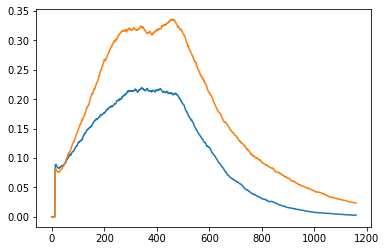

In [19]:
download( experiment.uid.hex, manifest.output_dl_folder, manifest.output_files_to_get )
subdir = os.listdir(manifest.output_dl_folder)[-1] # get the most recent
hiv_prev = json.load( open( manifest.output_dl_folder + "/" + subdir + "/" + "output/InsetChart.json" ) )["Channels"]["Infected"]["Data"]
plt.plot( hiv_prev_baseline )
plt.plot( hiv_prev )

Now we're going to set up ART distribution based on data. First, we're going to put a subset of people who get infected into an identifiable "Positive Status Known" state, approximating the results of the various means by which people get tested and get their results.

In [20]:
def _distribute_psk_tracker_by_age_and_sex( camp, min_age, max_age, sex, tvmap ):
    """
    Internal function to do the 'dirty work' to support 'add_pos_status_known_tracker'.
    """
    # First, give everyone who enters the HIV Latent stage a property that lets 
    # us target them with a "Faux Tested" intervention AND property.
    import emodpy_hiv.interventions.reftracker as reftracker
    # Listen for LatentStage events and set PositiveStatus
    pvc_psk = comm.PropertyValueChanger( camp, Target_Property_Key="TestingStatus", Target_Property_Value="ELIGIBLE", New_Property_Value="" )
    add_triggered_event( camp, in_trigger="HIVInfectionStageEnteredLatent", out_iv=pvc_psk, event_name="Set Eligible for Pos Status Known" )

    # Now, here's what we're going to do...
    # 1) Give out something like the above, that triggers off of HIVInfectionStageEnteredLatent and set an IP for targeting.
    # 2) Give out a ref tracker that filters on the target IP above but distributes a Placebo/MedicalRecord with the name "PositiveStatusKnown" or something. This also sets an IP InterventionStatus:ARTEligible or something nasty. The placebo can be a delay or no-effect vaccine or something for now.
    status_known_medrec = comm.HSB( camp, Tendency=0, Name="PositiveStatusKnown" )
    status_known_medrec.New_Property_Value=ART_eligible_tag # Placeholder for "InterventionStatus:ARTEligible
    event = reftracker.DistributeIVByRefTrack( camp, Start_Day=1, Intervention=status_known_medrec, TVMap=tvmap, Property_Restrictions="TestingStatus:ELIGIBLE", Target_Age_Min=min_age, Target_Age_Max=max_age, Target_Gender=sex )
    camp.add( event )


def add_pos_status_known_tracker( camp ):
    """
    Put some subset of people who have entered latent infection stage into "Positive status known" 'state',
    which makes them ART-eligible. Drive this from data instead of creating a complex cascade that
    uses actually testing, etc. These coverages can vary by age group, sex, and simulation date.
    """
    tvmap = { "1962": 0.5, 1963: 0.6, 1964: 0.7 } # just some simple test version
    # tvmap = { "1962": 0.99, 1963: 0.99, 1964: 0.99 } # almost everyone
    _distribute_psk_tracker_by_age_and_sex( camp, ck.PSK_Male_Age_Lower_Bound, ck.PSK_Male_Age_Upper_Bound, "Male", tvmap )
    _distribute_psk_tracker_by_age_and_sex( camp, ck.PSK_Female_Age_Lower_Bound, ck.PSK_Female_Age_Upper_Bound, "Female", tvmap )


In [21]:
def build_camp( art_coverage = 1.0 ):
    """
        Build a campaign input file for the DTK using emod_api type functions or helpers from this module. 
        Note that 'camp' is short for 'campaign'.
        You can name this function whatever you want, it just has to match what you pass in from_default2.
    """

    # Setup
    import emod_api.campaign as camp
    camp.set_schema( manifest.schema_file )

    def timestep_from_year( year ):
        return (year-params.base_year)*365

    # Crudely seed the infection
    event = ob.seed_infections( camp, start_day=timestep_from_year( 1961.5 ) )
    camp.add( event )
    add_sti_coinfection_complex(camp, ck.STI_Low_Risk_Coverage, ck.STI_Med_Risk_Coverage, ck.STI_High_Risk_Coverage)
    add_csw( camp )
    add_pos_status_known_tracker( camp )

    return camp

task = EMODTask.from_default2(config_path="config.json", eradication_path=manifest.eradication_path, campaign_builder=build_camp, demog_builder=build_demog, schema_path=manifest.schema_file, param_custom_cb=set_param_fn, ep4_custom_cb=None)
experiment  = Experiment.from_builder(builder, task, name=params.exp_name) 
experiment.run(wait_until_done=True, platform=platform)

Wrote 'default_config.json' file.
DEBUG: write_config_from_default_and_params invoked with default_config.json, <function set_param_fn at 0x7f674245b598>.
DEBUG: Calling load_default_config_as_rod.
DEBUG: Calling set_fn.
Fertility data file column names are ountry, NA, ID, Nothing, AreaCode, Years, 15-19, 20-24, 25-29, 30-34, 35-39, 40-45, 45-49
Found 15 rows of fertility data.
Generating demographics file demographics.json.
Campaign is publishing the following events:
CaughtNonHIVSTI
CSW_Dropout
NoTrigger
CSW_Uptake
Campaign is listening to the following events:
CSW_Uptake
CSW_Dropout
STIDebut
HIVInfectionStageEnteredLatent
Campaign is IGNORING the following events:
CaughtNonHIVSTI
NoTrigger
Campaign is LISTENING to the following non-campaign events:
HIVInfectionStageEnteredLatent
STIDebut
Campaign builder save returned campaign.json as file.
Found adhoc events in campaign. Needs some special processing behind the scenes.

The created experiment can be viewed at https://comps.idmod.or

Initializing objects for creation: 0simulation [00:00, ?simulation/s]

Campaign is publishing the following events:
CaughtNonHIVSTI
CSW_Dropout
NoTrigger
CSW_Uptake
Campaign is listening to the following events:
CSW_Uptake
CSW_Dropout
STIDebut
HIVInfectionStageEnteredLatent
Campaign is IGNORING the following events:
CaughtNonHIVSTI
NoTrigger
Campaign is LISTENING to the following non-campaign events:
HIVInfectionStageEnteredLatent
STIDebut
Campaign builder save returned campaign.json as file.


Creating Simulations on Comps: 100%|██████████| 1/1 [00:00<00:00, 15.05simulation/s]    


Found adhoc events in campaign. Needs some special processing behind the scenes.


Waiting on Experiment HIV Rakai Simpler CoC to Finish running: 100%|██████████| 1/1 [00:40<00:00, 40.78s/simulation]


The code above gives certain people a 'tracker' via individual properties. Therefore, to observe the effect we must generate a property report.

What we do next is actually distribute ART using the above tracker. We can select some percentage of people with the "Positive Status Known" property to receive ART.

In [22]:
def _distribute_art_by_ref_counter_by_age_and_sex( camp, art_coverage, min_age, max_age, sex, tvmap ):
    """
    Internal utility function to do the 'dirty work' to support distribute_art_by_ref_counter for a given
    min_age, max_age, and sex. art_coverage is simply for a demonstration campaign sweep.
    """
    import emodpy_hiv.interventions.reftracker as reftracker
    import emodpy_hiv.interventions.art as art
    new_art = art.new_intervention( camp )
    delayed_dropout_iv = hiv_utils.broadcast_event_delayed( camp, "ARTDropout", delay={ "Delay_Period": ck.ART_Duration } ) # make this duration a bit more sophisticated
    iv_tracking_name = None #"ART for " + sex + "s"
    # Old way of doing ART is ARTBasic + Delay->ARTDropout

    event = reftracker.DistributeIVByRefTrack( camp, Start_Day=1, Intervention=[new_art, delayed_dropout_iv], TVMap=tvmap, Property_Restrictions=ART_eligible_tag, Target_Gender=sex, Target_Age_Min=min_age, Target_Age_Max=max_age, IV_Tracking_Name=iv_tracking_name )
    camp.add( event )


def distribute_art_by_ref_counter( camp, art_coverage ):
    """
    For the ART:
    3) Give out a ref tracker that filters on the target IP InterventionStatus:ARTEligible and distributes ART.
    """
    #tvmap = { "1970": art_coverage/10, 1976: art_coverage/2, 1983: art_coverage }
    tvmap = { "1972": art_coverage/10, 1978: art_coverage/2, 1985: art_coverage }
    _distribute_art_by_ref_counter_by_age_and_sex( camp, art_coverage, ck.ART_Male_Age_Lower_Bound, ck.ART_Male_Age_Upper_Bound, "Male", tvmap )
    _distribute_art_by_ref_counter_by_age_and_sex( camp, art_coverage, ck.ART_Female_Age_Lower_Bound, ck.ART_Female_Age_Upper_Bound, "Female", tvmap )

In [23]:
def build_camp( art_coverage = 1.0 ):
    """
        Build a campaign input file for the DTK using emod_api type functions or helpers from this module. 
        Note that 'camp' is short for 'campaign'.
        You can name this function whatever you want, it just has to match what you pass in from_default2.
    """

    # Setup
    import emod_api.campaign as camp
    camp.set_schema( manifest.schema_file )

    def timestep_from_year( year ):
        return (year-params.base_year)*365

    # Crudely seed the infection
    event = ob.seed_infections( camp, start_day=timestep_from_year( 1961.5 ) )
    camp.add( event )

    add_sti_coinfection_complex(camp, ck.STI_Low_Risk_Coverage, ck.STI_Med_Risk_Coverage, ck.STI_High_Risk_Coverage)
    add_csw( camp )
    add_pos_status_known_tracker( camp )
    distribute_art_by_ref_counter( camp, art_coverage=1.0  )
    return camp

task = EMODTask.from_default2(config_path="config.json", eradication_path=manifest.eradication_path, campaign_builder=build_camp, demog_builder=build_demog, schema_path=manifest.schema_file, param_custom_cb=set_param_fn, ep4_custom_cb=None)
experiment  = Experiment.from_builder(builder, task, name=params.exp_name) 
experiment.run(wait_until_done=True, platform=platform)

Wrote 'default_config.json' file.
DEBUG: write_config_from_default_and_params invoked with default_config.json, <function set_param_fn at 0x7f674245b598>.
DEBUG: Calling load_default_config_as_rod.
DEBUG: Calling set_fn.
Fertility data file column names are ountry, NA, ID, Nothing, AreaCode, Years, 15-19, 20-24, 25-29, 30-34, 35-39, 40-45, 45-49
Found 15 rows of fertility data.
Generating demographics file demographics.json.
Campaign is publishing the following events:
CaughtNonHIVSTI
ARTDropout
CSW_Dropout
CSW_Uptake
NoTrigger
Campaign is listening to the following events:
CSW_Uptake
CSW_Dropout
STIDebut
HIVInfectionStageEnteredLatent
Campaign is IGNORING the following events:
CaughtNonHIVSTI
NoTrigger
ARTDropout
Campaign is LISTENING to the following non-campaign events:
HIVInfectionStageEnteredLatent
STIDebut
Campaign builder save returned campaign.json as file.
Found adhoc events in campaign. Needs some special processing behind the scenes.

The created experiment can be viewed at 

Initializing objects for creation: 0simulation [00:00, ?simulation/s]

Campaign is publishing the following events:
CaughtNonHIVSTI
ARTDropout
CSW_Dropout
CSW_Uptake
NoTrigger
Campaign is listening to the following events:
CSW_Uptake
CSW_Dropout
STIDebut
HIVInfectionStageEnteredLatent
Campaign is IGNORING the following events:
CaughtNonHIVSTI
NoTrigger
ARTDropout
Campaign is LISTENING to the following non-campaign events:
HIVInfectionStageEnteredLatent
STIDebut
Campaign builder save returned campaign.json as file.


Creating Simulations on Comps: 100%|██████████| 1/1 [00:00<00:00,  6.79simulation/s]    

Found adhoc events in campaign. Needs some special processing behind the scenes.



Waiting on Experiment HIV Rakai Simpler CoC to Finish running: 100%|██████████| 1/1 [01:02<00:00, 62.16s/simulation]



[Calculon]
{
   "endpoint": "https://comps.idmod.org",
   "environment": "Calculon"
}
Attempting to download ['output/InsetChart.json'] for experiment 4739c9b7cd26ec119ecd9440c9bee941 into COMPS_output_downloads.
Creating Watcher

The running WorkItem can be viewed at https://comps.idmod.org/#explore/WorkItems?filters=Id=3246fcdc-cd26-ec11-9ecd-9440c9bee941



Waiting on WorkItem Filter outputs for Experiment 4739c9b7-cd26-ec11-9ecd-9440c9bee941: 100%|██████████| 1/1 [00:05<00:00,  5.08s/workitem]

Removing COMPS_output_downloads/output.zip
Deleting workitem 3246fcdc-cd26-ec11-9ecd-9440c9bee941


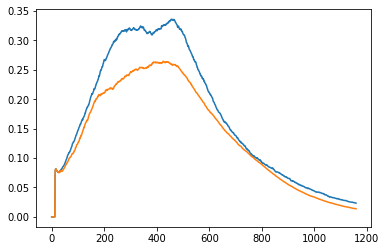

In [24]:
download( experiment.uid.hex, manifest.output_dl_folder, manifest.output_files_to_get )
subdir = os.listdir(manifest.output_dl_folder)[-1] # get the most recent
hiv_prev_prev = hiv_prev
hiv_prev = json.load( open( manifest.output_dl_folder + "/" + subdir + "/" + "output/InsetChart.json" ) )["Channels"]["Infected"]["Data"]
plt.plot( hiv_prev_prev )
plt.plot( hiv_prev )

The orange curve shows how over time ART distribution bent the prevalence curve (blue is from previous run with STI co-infection and CSWs).